# Demo Notebook with simulated RGCs data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import matplotlib as mpl
#import MEI

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [4]:
#Use dataloaders with generated RGC data
from lurz2020.datasets.mouse_loaders import static_loaders

paths = ['D://inception_loop/RGC_sim_data/data/static20022021_check_images']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders_RGCs = static_loaders(**dataset_config)
dat = FileTreeDataset('D://inception_loop/RGC_sim_data/data/static20022021_check_images', "images", "responses")

### Look at the data

In [5]:
tier = 'train'
dataset_name = '20022021_check_images'

images, responses = [], []
for x, y in dataloaders_RGCs[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20022021_check_images" contains the responses of 2304 RGC neurons to 10000 images


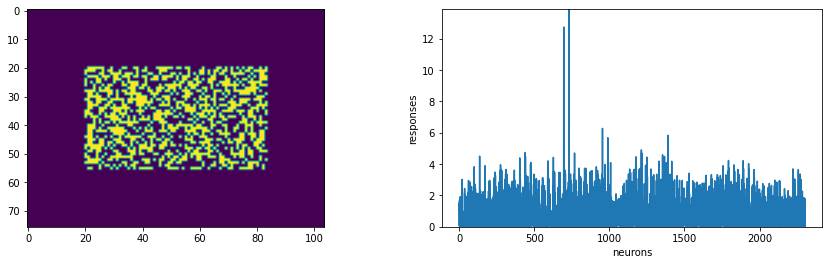

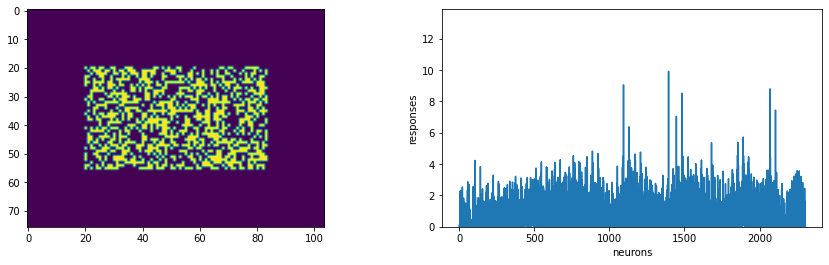

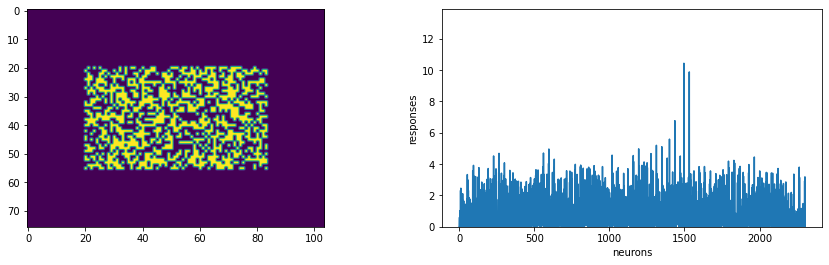

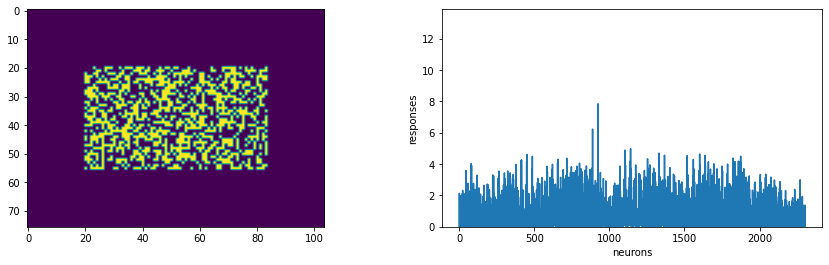

In [6]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model, transfer core, train and evaluate performance

Get 1 instance of the model for STA:

In [7]:
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

n_seeds = 4

#Model config
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}


#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'detach_core': True}

models = []
train_correlation_models = []
validation_correlation_models = []
for i in range(n_seeds): 

    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=i)
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders_RGCs["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False))
    
    print('-----------------------------------------')
    print(f'Model instance #{i}')
    print('Correlation (train set):      {0:.3f}'.format(train_correlation_models[i]))
    print('Correlation (validation set): {0:.3f}'.format(validation_correlation_models[i]))
    print('-----------------------------------------')

    models.append(model)
    #Save model state for loading later
    torch.save(model_state, 'D://inception_loop/RGC_sim_data/models/model_checkerboard_padded_tunned'+str(i)+'.pth')

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.82it/s]


[001|00/05] ---> 0.009702472016215324


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


[002|00/05] ---> 0.020826341584324837


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.70it/s]


[003|00/05] ---> 0.03418656811118126


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.74it/s]


[004|00/05] ---> 0.05073756352066994


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


[005|00/05] ---> 0.06989885866641998


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[006|00/05] ---> 0.08814139664173126


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.74it/s]


[007|00/05] ---> 0.10826362669467926


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.69it/s]


[008|00/05] ---> 0.12816458940505981


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


[009|00/05] ---> 0.14493073523044586


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.74it/s]


[010|00/05] ---> 0.16236107051372528


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.77it/s]


[011|00/05] ---> 0.17689651250839233


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


[012|00/05] ---> 0.1917399764060974


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.81it/s]


[013|00/05] ---> 0.20520836114883423


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.60it/s]


[014|00/05] ---> 0.2159426510334015


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.71it/s]


[015|00/05] ---> 0.23179759085178375


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


[016|00/05] ---> 0.24319331347942352


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[017|00/05] ---> 0.25677943229675293


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.76it/s]


[018|00/05] ---> 0.2671234905719757


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.52it/s]


[019|00/05] ---> 0.2810841500759125


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.77it/s]


[020|00/05] ---> 0.29562637209892273


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


[021|00/05] ---> 0.30477041006088257


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[022|00/05] ---> 0.31436505913734436


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[023|00/05] ---> 0.32507795095443726


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.77it/s]


[024|00/05] ---> 0.33300015330314636


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.56it/s]


[025|00/05] ---> 0.3427842855453491


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.61it/s]


[026|00/05] ---> 0.3521219491958618


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.40it/s]


[027|00/05] ---> 0.35914766788482666


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


[028|00/05] ---> 0.36615681648254395


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


[029|00/05] ---> 0.3714071214199066


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.56it/s]


[030|00/05] ---> 0.381554514169693


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.59it/s]


[031|00/05] ---> 0.38539233803749084


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.50it/s]


[032|00/05] ---> 0.3928874731063843


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


[033|00/05] ---> 0.39677345752716064


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[034|00/05] ---> 0.400752454996109


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[035|00/05] ---> 0.406558632850647


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[036|00/05] ---> 0.4118083417415619


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[037|00/05] ---> 0.4152040481567383


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[038|00/05] ---> 0.418908953666687


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[039|00/05] ---> 0.4232294261455536


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


[040|00/05] ---> 0.4287800192832947


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[041|00/05] ---> 0.4311749339103699


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[042|00/05] ---> 0.43493854999542236


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[043|00/05] ---> 0.4389188587665558


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[044|00/05] ---> 0.4421390891075134


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[045|00/05] ---> 0.44567081332206726


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[046|00/05] ---> 0.44812971353530884


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[047|00/05] ---> 0.4496372938156128


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[048|00/05] ---> 0.4531876742839813


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[049|00/05] ---> 0.4542642831802368


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[050|00/05] ---> 0.45703819394111633


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[051|00/05] ---> 0.4578610956668854


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[052|00/05] ---> 0.4615206718444824


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[053|00/05] ---> 0.4633508324623108


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[054|00/05] ---> 0.46637895703315735


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[055|00/05] ---> 0.4707869291305542


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[056|00/05] ---> 0.47219446301460266


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[057|01/05] -/-> 0.47103703022003174


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[058|01/05] ---> 0.4735492169857025


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[059|00/05] ---> 0.47606971859931946


Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[060|00/05] ---> 0.47797510027885437


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[061|00/05] ---> 0.47848060727119446


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[062|00/05] ---> 0.4827583134174347


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[063|01/05] -/-> 0.4824793040752411


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[064|01/05] ---> 0.48430320620536804


Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[065|00/05] ---> 0.4866933226585388


Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[066|00/05] ---> 0.4873048961162567


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[067|00/05] ---> 0.4902077913284302


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[068|00/05] ---> 0.49279773235321045


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[069|00/05] ---> 0.4949631094932556


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[070|01/05] -/-> 0.4946809411048889


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[071|01/05] ---> 0.4967736005783081


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[072|00/05] ---> 0.4987146556377411


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[073|00/05] ---> 0.4993128180503845


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[074|00/05] ---> 0.49968433380126953


Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[075|00/05] ---> 0.5006694793701172


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[076|00/05] ---> 0.5032148361206055


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[077|01/05] -/-> 0.5026605129241943


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[078|01/05] ---> 0.5057446956634521


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[079|01/05] -/-> 0.5052661895751953


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[080|01/05] ---> 0.5065833330154419


Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[081|00/05] ---> 0.5071426033973694


Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[082|00/05] ---> 0.5092433094978333


Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.59it/s]


[083|00/05] ---> 0.5114214420318604


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.72it/s]


[084|00/05] ---> 0.5118318200111389


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.84it/s]


[085|00/05] ---> 0.5123456120491028


Epoch 86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.83it/s]


[086|00/05] ---> 0.5140634179115295


Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


[087|00/05] ---> 0.5155030488967896


Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


[088|00/05] ---> 0.5167853832244873


Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[089|00/05] ---> 0.5173549056053162


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.82it/s]


[090|00/05] ---> 0.5194001197814941


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.84it/s]


[091|00/05] ---> 0.5197249054908752


Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.77it/s]


[092|00/05] ---> 0.520348846912384


Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.82it/s]


[093|00/05] ---> 0.5224003195762634


Epoch 94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.76it/s]


[094|01/05] -/-> 0.5221461653709412


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[095|01/05] ---> 0.5235016345977783


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


[096|00/05] ---> 0.5243212580680847


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.78it/s]


[097|00/05] ---> 0.5255510807037354


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[098|00/05] ---> 0.527796745300293


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[099|00/05] ---> 0.5288859605789185


Epoch 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[100|00/05] ---> 0.5296758413314819


Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.82it/s]


[101|00/05] ---> 0.532217800617218


Epoch 102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[102|00/05] ---> 0.5323540568351746


Epoch 103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.86it/s]


[103|01/05] -/-> 0.532228946685791


Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.76it/s]


[104|01/05] ---> 0.5347393751144409


Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.78it/s]


[105|01/05] -/-> 0.5347175002098083


Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.85it/s]


[106|01/05] ---> 0.5367194414138794


Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.33it/s]


[107|00/05] ---> 0.5370458960533142


Epoch 108: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[108|00/05] ---> 0.537098228931427


Epoch 109: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[109|00/05] ---> 0.538767397403717


Epoch 110: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[110|00/05] ---> 0.5396726727485657


Epoch 111: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[111|01/05] -/-> 0.539099931716919


Epoch 112: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[112|02/05] -/-> 0.5391013622283936


Epoch 113: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[113|02/05] ---> 0.5397626161575317


Epoch 114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[114|01/05] -/-> 0.5394480228424072


Epoch 115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[115|01/05] ---> 0.5414330959320068


Epoch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[116|00/05] ---> 0.5416450500488281


Epoch 117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[117|00/05] ---> 0.5426025986671448


Epoch 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[118|00/05] ---> 0.543034017086029


Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[119|01/05] -/-> 0.5414097309112549


Epoch 120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[120|01/05] ---> 0.5440233945846558


Epoch 121: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[121|01/05] -/-> 0.5433911085128784


Epoch 122: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[122|02/05] -/-> 0.5437396168708801


Epoch 123: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[123|03/05] -/-> 0.5432525277137756


Epoch 124: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[124|03/05] ---> 0.54426509141922


Epoch 125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[125|00/05] ---> 0.5453107357025146


Epoch 126: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[126|00/05] ---> 0.5475531816482544


Epoch 127: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[127|01/05] -/-> 0.5469509959220886


Epoch 128: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[128|01/05] ---> 0.5476152300834656


Epoch 129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[129|00/05] ---> 0.5488658547401428


Epoch 130: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[130|00/05] ---> 0.5497310161590576


Epoch 131: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[131|00/05] ---> 0.5516627430915833


Epoch 132: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[132|01/05] -/-> 0.5511656999588013


Epoch 133: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[133|02/05] -/-> 0.5509580373764038


Epoch 134: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[134|02/05] ---> 0.5521817803382874


Epoch 135: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[135|01/05] -/-> 0.552135705947876


Epoch 136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[136|01/05] ---> 0.5525935292243958


Epoch 137: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[137|01/05] -/-> 0.5520029067993164


Epoch 138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[138|01/05] ---> 0.5532233715057373


Epoch 139: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[139|00/05] ---> 0.5540749430656433


Epoch 140: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[140|01/05] -/-> 0.5535042881965637


Epoch 141: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[141|01/05] ---> 0.5562275052070618


Epoch 142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[142|01/05] -/-> 0.5557267665863037


Epoch 143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[143|02/05] -/-> 0.5560682415962219


Epoch 144: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[144|03/05] -/-> 0.5556313991546631


Epoch 145: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[145|04/05] -/-> 0.5559497475624084


Epoch 146: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[146|04/05] ---> 0.557612419128418


Epoch 147: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[147|01/05] -/-> 0.5571136474609375


Epoch 148: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[148|01/05] ---> 0.5579577684402466


Epoch 149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[149|01/05] -/-> 0.557678759098053


Epoch 150: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[150|01/05] ---> 0.5588139891624451


Epoch 151: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[151|00/05] ---> 0.5597341060638428


Epoch 152: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[152|01/05] -/-> 0.5582553744316101


Epoch 153: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[153|01/05] ---> 0.5609185099601746


Epoch 154: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[154|01/05] -/-> 0.5607243776321411


Epoch 155: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[155|02/05] -/-> 0.5606611967086792


Epoch 156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[156|03/05] -/-> 0.55973219871521


Epoch 157: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[157|03/05] ---> 0.5611250996589661


Epoch 158: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.04it/s]


[158|01/05] -/-> 0.5595390200614929


Epoch 159: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[159|02/05] -/-> 0.5610997080802917


Epoch 160: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[160|03/05] -/-> 0.5601274967193604


Epoch 161: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[161|04/05] -/-> 0.5606724619865417


Epoch 162: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[162|04/05] ---> 0.5615686774253845


Epoch 163: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[163|00/05] ---> 0.5618135929107666


Epoch 164: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.04it/s]


[164|01/05] -/-> 0.5615149140357971


Epoch 165: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[165|02/05] -/-> 0.5609802603721619


Epoch 166: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[166|02/05] ---> 0.562245786190033


Epoch 167: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[167|00/05] ---> 0.5624417066574097


Epoch 168: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[168|01/05] -/-> 0.562187910079956


Epoch 169: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[169|02/05] -/-> 0.5610921382904053


Epoch 170: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[170|02/05] ---> 0.5630608797073364


Epoch 171: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[171|01/05] -/-> 0.5627076625823975


Epoch 172: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[172|02/05] -/-> 0.5628512501716614


Epoch 173: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[173|03/05] -/-> 0.563061535358429


Epoch 174: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[174|04/05] -/-> 0.5624632239341736


Epoch 175: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[175|04/05] ---> 0.5640916228294373


Epoch 176: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[176|00/05] ---> 0.5642798542976379


Epoch 177: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[177|01/05] -/-> 0.5641089677810669


Epoch 178: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[178|02/05] -/-> 0.5638144016265869


Epoch 179: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[179|03/05] -/-> 0.5639475584030151


Epoch 180: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[180|03/05] ---> 0.5642929673194885


Epoch 181: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[181|01/05] -/-> 0.5633174180984497


Epoch 182: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[182|02/05] -/-> 0.5641991496086121


Epoch 183: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[183|02/05] ---> 0.564500093460083


Epoch 184: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[184|00/05] ---> 0.564646303653717


Epoch 185: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[185|01/05] -/-> 0.5632236003875732


Epoch 186: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[186|01/05] ---> 0.5649986863136292


Epoch 187: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.04it/s]


[187|00/05] ---> 0.56618732213974


Epoch 188: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[188|01/05] -/-> 0.5651652216911316


Epoch 189: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[189|02/05] -/-> 0.5659872889518738


Epoch 190: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[190|02/05] ---> 0.5663950443267822


Epoch 191: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[191|01/05] -/-> 0.565507173538208


Epoch 192: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[192|02/05] -/-> 0.5642311573028564


Epoch 193: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[193|03/05] -/-> 0.5647232532501221


Epoch 194: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[194|04/05] -/-> 0.5663288831710815


Epoch 195: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[195|04/05] ---> 0.567439615726471


Epoch 196: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[196|01/05] -/-> 0.5662829279899597


Epoch 197: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[197|01/05] ---> 0.568671464920044


Epoch 198: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[198|01/05] -/-> 0.5669594407081604


Epoch 199: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[199|02/05] -/-> 0.5664416551589966


Epoch 200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[200|03/05] -/-> 0.5679233074188232
Restoring best model! 0.567923 ---> 0.568671
-----------------------------------------
Model instance #0
Correlation (train set):      0.572
Correlation (validation set): 0.569
-----------------------------------------


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.81it/s]


[001|00/05] ---> 0.011374758556485176


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[002|00/05] ---> 0.023195208981633186


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


[003|00/05] ---> 0.03740924596786499


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[004|00/05] ---> 0.051930684596300125


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[005|00/05] ---> 0.07177873700857162


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.82it/s]


[006|00/05] ---> 0.09249583631753922


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[007|00/05] ---> 0.11331364512443542


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[008|00/05] ---> 0.1312118023633957


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.38it/s]


[009|00/05] ---> 0.14890581369400024


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.52it/s]


[010|00/05] ---> 0.16680218279361725


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  4.98it/s]


[011|00/05] ---> 0.18400755524635315


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.54it/s]


[012|00/05] ---> 0.19980674982070923


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.75it/s]


[013|00/05] ---> 0.21198715269565582


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[014|00/05] ---> 0.22608399391174316


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


[015|00/05] ---> 0.2382963001728058


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[016|00/05] ---> 0.2500481903553009


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.75it/s]


[017|00/05] ---> 0.2593081593513489


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.61it/s]


[018|00/05] ---> 0.26907792687416077


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.54it/s]


[019|00/05] ---> 0.2803973853588104


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.71it/s]


[020|00/05] ---> 0.2912188768386841


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[021|00/05] ---> 0.30154189467430115


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[022|00/05] ---> 0.312481164932251


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[023|00/05] ---> 0.3207791745662689


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[024|00/05] ---> 0.3300294876098633


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[025|00/05] ---> 0.34237635135650635


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[026|00/05] ---> 0.35023483633995056


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[027|00/05] ---> 0.3569182753562927


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[028|00/05] ---> 0.3652149736881256


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[029|00/05] ---> 0.37043821811676025


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[030|00/05] ---> 0.3784646689891815


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[031|00/05] ---> 0.38343533873558044


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[032|00/05] ---> 0.39127030968666077


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[033|00/05] ---> 0.3955400288105011


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[034|00/05] ---> 0.3998558223247528


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[035|00/05] ---> 0.40386855602264404


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[036|00/05] ---> 0.41110551357269287


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[037|00/05] ---> 0.4157244861125946


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[038|00/05] ---> 0.4228648245334625


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[039|00/05] ---> 0.42518851161003113


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[040|00/05] ---> 0.4314098060131073


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.82it/s]


[041|00/05] ---> 0.43402352929115295


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


[042|00/05] ---> 0.4395903944969177


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[043|00/05] ---> 0.4441433548927307


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:35<00:00,  4.43it/s]


[044|00/05] ---> 0.4476569592952728


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.50it/s]


[045|00/05] ---> 0.45074203610420227


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.56it/s]


[046|00/05] ---> 0.4544623792171478


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.61it/s]


[047|00/05] ---> 0.45717912912368774


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.53it/s]


[048|00/05] ---> 0.460382878780365


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.53it/s]


[049|00/05] ---> 0.46246448159217834


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.58it/s]


[050|00/05] ---> 0.4647083878517151


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.62it/s]


[051|00/05] ---> 0.4679669737815857


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.50it/s]


[052|00/05] ---> 0.4688299000263214


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.54it/s]


[053|00/05] ---> 0.47253403067588806


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.63it/s]


[054|00/05] ---> 0.4756404161453247


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.61it/s]


[055|00/05] ---> 0.4763597846031189


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  4.98it/s]


[056|00/05] ---> 0.47918811440467834


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[057|00/05] ---> 0.48221027851104736


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[058|00/05] ---> 0.4834453761577606


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[059|00/05] ---> 0.48491424322128296


Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.75it/s]


[060|00/05] ---> 0.4878709614276886


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.84it/s]


[061|00/05] ---> 0.48945850133895874


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.60it/s]


[062|00/05] ---> 0.4912196397781372


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[063|00/05] ---> 0.4933565557003021


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.74it/s]


[064|00/05] ---> 0.49599355459213257


Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.70it/s]


[065|00/05] ---> 0.49703726172447205


Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.80it/s]


[066|00/05] ---> 0.49921587109565735


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


[067|00/05] ---> 0.5015541315078735


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[068|00/05] ---> 0.5049135684967041


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.55it/s]


[069|00/05] ---> 0.5072692036628723


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.79it/s]


[070|00/05] ---> 0.5082749128341675


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[071|00/05] ---> 0.511897623538971


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[072|01/05] -/-> 0.5112411379814148


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


[073|01/05] ---> 0.5121262073516846


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[074|00/05] ---> 0.5136656165122986


Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[075|00/05] ---> 0.5148093700408936


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[076|00/05] ---> 0.5150042772293091


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[077|00/05] ---> 0.5159049034118652


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[078|00/05] ---> 0.517894446849823


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[079|01/05] -/-> 0.5176206231117249


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[080|01/05] ---> 0.5197155475616455


Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[081|00/05] ---> 0.5206149220466614


Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[082|00/05] ---> 0.523027241230011


Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[083|00/05] ---> 0.5253505706787109


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[084|00/05] ---> 0.5253775715827942


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[085|01/05] -/-> 0.5253022313117981


Epoch 86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


[086|01/05] ---> 0.5287140607833862


Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.72it/s]


[087|01/05] -/-> 0.5276137590408325


Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[088|01/05] ---> 0.5291181206703186


Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[089|00/05] ---> 0.5303061604499817


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[090|00/05] ---> 0.5320172309875488


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[091|00/05] ---> 0.5326123833656311


Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[092|00/05] ---> 0.5332109928131104


Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[093|00/05] ---> 0.5346896648406982


Epoch 94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[094|01/05] -/-> 0.5344851016998291


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[095|01/05] ---> 0.537080705165863


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[096|00/05] ---> 0.5371279120445251


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[097|01/05] -/-> 0.5370093584060669


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[098|01/05] ---> 0.5380555987358093


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[099|00/05] ---> 0.5388844013214111


Epoch 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[100|00/05] ---> 0.5393504500389099


Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[101|01/05] -/-> 0.5389934182167053


Epoch 102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[102|01/05] ---> 0.5405380725860596


Epoch 103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[103|00/05] ---> 0.5418843030929565


Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[104|00/05] ---> 0.5434992909431458


Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[105|01/05] -/-> 0.5421961545944214


Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[106|01/05] ---> 0.5445801615715027


Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[107|00/05] ---> 0.545364260673523


Epoch 108: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[108|00/05] ---> 0.5456438064575195


Epoch 109: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[109|00/05] ---> 0.5468896627426147


Epoch 110: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[110|01/05] -/-> 0.5467590689659119


Epoch 111: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[111|01/05] ---> 0.5470079779624939


Epoch 112: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[112|00/05] ---> 0.5481361746788025


Epoch 113: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[113|01/05] -/-> 0.547485888004303


Epoch 114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[114|02/05] -/-> 0.5472667217254639


Epoch 115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[115|03/05] -/-> 0.5479094982147217


Epoch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[116|04/05] -/-> 0.5478478670120239


Epoch 117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[117|04/05] ---> 0.5489075183868408


Epoch 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[118|00/05] ---> 0.5493977069854736


Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[119|01/05] -/-> 0.548711359500885


Epoch 120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[120|01/05] ---> 0.550190269947052


Epoch 121: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[121|01/05] -/-> 0.5494181513786316


Epoch 122: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[122|01/05] ---> 0.5513210296630859


Epoch 123: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[123|00/05] ---> 0.5513531565666199


Epoch 124: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[124|00/05] ---> 0.5523202419281006


Epoch 125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[125|00/05] ---> 0.5529558658599854


Epoch 126: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[126|01/05] -/-> 0.552768349647522


Epoch 127: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[127|02/05] -/-> 0.5527985692024231


Epoch 128: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[128|02/05] ---> 0.5531138181686401


Epoch 129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[129|00/05] ---> 0.5551429986953735


Epoch 130: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[130|00/05] ---> 0.5558639168739319


Epoch 131: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[131|01/05] -/-> 0.5556026101112366


Epoch 132: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[132|01/05] ---> 0.5567428469657898


Epoch 133: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[133|01/05] -/-> 0.5564759373664856


Epoch 134: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[134|01/05] ---> 0.5595077872276306


Epoch 135: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[135|01/05] -/-> 0.5571892261505127


Epoch 136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[136|02/05] -/-> 0.5575181245803833


Epoch 137: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[137|03/05] -/-> 0.5577795505523682


Epoch 138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[138|04/05] -/-> 0.5582883358001709


Epoch 139: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[139|05/05] -/-> 0.5592873096466064


Epoch 140:   1%|▋                                                                                                    | 1/157 [00:00<00:21,  7.09it/s]

Restoring best model after lr decay! 0.559287 ---> 0.559508


Epoch 140: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


Epoch   140: reducing learning rate of group 0 to 1.5000e-03.
[140|01/05] -/-> 0.5585519671440125


Epoch 141: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[141|01/05] ---> 0.5638206005096436


Epoch 142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[142|01/05] -/-> 0.5630698800086975


Epoch 143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[143|02/05] -/-> 0.5635695457458496


Epoch 144: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[144|02/05] ---> 0.5650883913040161


Epoch 145: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[145|01/05] -/-> 0.5642163753509521


Epoch 146: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[146|02/05] -/-> 0.5649874210357666


Epoch 147: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[147|03/05] -/-> 0.5642092823982239


Epoch 148: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[148|04/05] -/-> 0.5643836855888367


Epoch 149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[149|05/05] -/-> 0.5648524165153503


Epoch 150:   1%|▋                                                                                                    | 1/157 [00:00<00:21,  7.35it/s]

Restoring best model after lr decay! 0.564852 ---> 0.565088


Epoch 150: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


Epoch   150: reducing learning rate of group 0 to 4.5000e-04.
[150|01/05] -/-> 0.5642584562301636


Epoch 151: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[151|01/05] ---> 0.5654425024986267


Epoch 152: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[152|00/05] ---> 0.5660527348518372


Epoch 153: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[153|01/05] -/-> 0.5659916996955872


Epoch 154: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[154|02/05] -/-> 0.5657381415367126


Epoch 155: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[155|02/05] ---> 0.5663061141967773


Epoch 156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[156|01/05] -/-> 0.5656559467315674


Epoch 157: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[157|02/05] -/-> 0.5655218362808228


Epoch 158: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[158|03/05] -/-> 0.565572202205658


Epoch 159: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[159|04/05] -/-> 0.5649732947349548


Epoch 160: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[160|05/05] -/-> 0.5651538372039795
Restoring best model after lr decay! 0.565154 ---> 0.566306
Restoring best model! 0.566306 ---> 0.566306
-----------------------------------------
Model instance #1
Correlation (train set):      0.571
Correlation (validation set): 0.566
-----------------------------------------


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[001|00/05] ---> 0.009776904247701168


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.82it/s]


[002|00/05] ---> 0.021828681230545044


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[003|00/05] ---> 0.03778927028179169


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[004|00/05] ---> 0.0561368390917778


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[005|00/05] ---> 0.08016833662986755


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[006|00/05] ---> 0.10040371865034103


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


[007|00/05] ---> 0.12058618664741516


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[008|00/05] ---> 0.14060384035110474


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[009|00/05] ---> 0.15898460149765015


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[010|00/05] ---> 0.17681683599948883


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


[011|00/05] ---> 0.19413387775421143


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[012|00/05] ---> 0.2094840705394745


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[013|00/05] ---> 0.22614707052707672


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[014|00/05] ---> 0.23996098339557648


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


[015|00/05] ---> 0.25690147280693054


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[016|00/05] ---> 0.2718476355075836


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[017|00/05] ---> 0.2866949439048767


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[018|00/05] ---> 0.2971046268939972


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[019|00/05] ---> 0.3067691922187805


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


[020|00/05] ---> 0.3177046477794647


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[021|00/05] ---> 0.3245266377925873


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[022|00/05] ---> 0.3346922695636749


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[023|00/05] ---> 0.3400942087173462


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[024|00/05] ---> 0.3484010696411133


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[025|00/05] ---> 0.3558851480484009


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[026|00/05] ---> 0.3622933328151703


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[027|00/05] ---> 0.36999425292015076


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[028|00/05] ---> 0.3795054852962494


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[029|00/05] ---> 0.3866301476955414


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[030|00/05] ---> 0.3958926796913147


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[031|00/05] ---> 0.3994370698928833


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[032|00/05] ---> 0.40530407428741455


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[033|00/05] ---> 0.4102592170238495


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[034|00/05] ---> 0.4155970811843872


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[035|00/05] ---> 0.4208625853061676


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[036|00/05] ---> 0.4246369004249573


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[037|00/05] ---> 0.4297159016132355


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[038|00/05] ---> 0.43537139892578125


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[039|00/05] ---> 0.43788138031959534


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[040|00/05] ---> 0.44311708211898804


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[041|00/05] ---> 0.4453643262386322


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[042|00/05] ---> 0.45018354058265686


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[043|00/05] ---> 0.4531390368938446


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[044|00/05] ---> 0.46024200320243835


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[045|00/05] ---> 0.4650641083717346


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[046|00/05] ---> 0.4674036204814911


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[047|00/05] ---> 0.47138655185699463


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[048|00/05] ---> 0.4755915403366089


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[049|00/05] ---> 0.4791889786720276


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[050|00/05] ---> 0.4812776744365692


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[051|00/05] ---> 0.48427337408065796


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[052|00/05] ---> 0.4871995151042938


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[053|00/05] ---> 0.4906175434589386


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[054|00/05] ---> 0.49277639389038086


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[055|00/05] ---> 0.49573051929473877


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[056|00/05] ---> 0.49815648794174194


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[057|00/05] ---> 0.5030924677848816


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[058|00/05] ---> 0.5039640069007874


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[059|00/05] ---> 0.5080813765525818


Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[060|00/05] ---> 0.5096878409385681


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[061|00/05] ---> 0.5101827383041382


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[062|00/05] ---> 0.5144551992416382


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[063|00/05] ---> 0.5153345465660095


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[064|00/05] ---> 0.5172817707061768


Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[065|00/05] ---> 0.5194701552391052


Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[066|00/05] ---> 0.5200397968292236


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[067|00/05] ---> 0.5211654305458069


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[068|00/05] ---> 0.5242300033569336


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[069|00/05] ---> 0.5250334143638611


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[070|00/05] ---> 0.5272467732429504


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[071|00/05] ---> 0.5275914669036865


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[072|00/05] ---> 0.5316352844238281


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[073|01/05] -/-> 0.5315796732902527


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[074|01/05] ---> 0.5334693789482117


Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[075|00/05] ---> 0.5352402925491333


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[076|01/05] -/-> 0.5347619652748108


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[077|01/05] ---> 0.5367786884307861


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[078|00/05] ---> 0.5378686785697937


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[079|00/05] ---> 0.5403488874435425


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[080|00/05] ---> 0.5407907962799072


Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[081|00/05] ---> 0.5420774221420288


Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[082|00/05] ---> 0.5435687303543091


Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[083|01/05] -/-> 0.5434458255767822


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[084|01/05] ---> 0.5438941121101379


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[085|00/05] ---> 0.5451755523681641


Epoch 86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[086|00/05] ---> 0.5470340251922607


Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[087|00/05] ---> 0.5488383769989014


Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[088|00/05] ---> 0.5489579439163208


Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[089|00/05] ---> 0.5510691404342651


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[090|00/05] ---> 0.5519675016403198


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[091|00/05] ---> 0.5529093146324158


Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[092|01/05] -/-> 0.551964521408081


Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[093|02/05] -/-> 0.5522568821907043


Epoch 94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[094|02/05] ---> 0.554468035697937


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[095|01/05] -/-> 0.5542125701904297


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[096|02/05] -/-> 0.5543662309646606


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[097|02/05] ---> 0.5547900795936584


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[098|00/05] ---> 0.5562527179718018


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[099|00/05] ---> 0.5565578937530518


Epoch 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[100|01/05] -/-> 0.5557253360748291


Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[101|01/05] ---> 0.557388186454773


Epoch 102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[102|01/05] -/-> 0.5573012232780457


Epoch 103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[103|01/05] ---> 0.5580218434333801


Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


[104|00/05] ---> 0.5596248507499695


Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[105|00/05] ---> 0.5606740117073059


Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[106|00/05] ---> 0.5617892146110535


Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[107|01/05] -/-> 0.5609362721443176


Epoch 108: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[108|01/05] ---> 0.5628989934921265


Epoch 109: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[109|01/05] -/-> 0.5626332759857178


Epoch 110: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[110|01/05] ---> 0.5635820031166077


Epoch 111: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[111|00/05] ---> 0.5646680593490601


Epoch 112: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[112|01/05] -/-> 0.5635108351707458


Epoch 113: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[113|02/05] -/-> 0.5637412667274475


Epoch 114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[114|03/05] -/-> 0.5642178654670715


Epoch 115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[115|03/05] ---> 0.5652486085891724


Epoch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[116|00/05] ---> 0.565420389175415


Epoch 117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[117|00/05] ---> 0.566438615322113


Epoch 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[118|00/05] ---> 0.5664897561073303


Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[119|01/05] -/-> 0.5659412145614624


Epoch 120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[120|01/05] ---> 0.5673637390136719


Epoch 121: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[121|01/05] -/-> 0.5672692060470581


Epoch 122: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[122|01/05] ---> 0.5679090619087219


Epoch 123: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[123|00/05] ---> 0.5684124231338501


Epoch 124: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[124|01/05] -/-> 0.5677179098129272


Epoch 125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[125|02/05] -/-> 0.5675815343856812


Epoch 126: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[126|02/05] ---> 0.5689504146575928


Epoch 127: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[127|00/05] ---> 0.5699886679649353


Epoch 128: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[128|01/05] -/-> 0.5698649883270264


Epoch 129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[129|02/05] -/-> 0.5699305534362793


Epoch 130: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[130|03/05] -/-> 0.5693241953849792


Epoch 131: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[131|03/05] ---> 0.5714471936225891


Epoch 132: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[132|01/05] -/-> 0.5698534846305847


Epoch 133: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[133|02/05] -/-> 0.5707111954689026


Epoch 134: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[134|02/05] ---> 0.571761429309845


Epoch 135: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[135|01/05] -/-> 0.5713907480239868


Epoch 136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[136|02/05] -/-> 0.5717601776123047


Epoch 137: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[137|03/05] -/-> 0.5708739757537842


Epoch 138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[138|04/05] -/-> 0.5703716278076172


Epoch 139: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[139|04/05] ---> 0.5721991658210754


Epoch 140: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[140|01/05] -/-> 0.5715587735176086


Epoch 141: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[141|01/05] ---> 0.5727905631065369


Epoch 142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[142|01/05] -/-> 0.5720807313919067


Epoch 143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[143|01/05] ---> 0.5730082392692566


Epoch 144: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[144|00/05] ---> 0.5735585689544678


Epoch 145: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[145|00/05] ---> 0.5741989016532898


Epoch 146: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[146|00/05] ---> 0.5742649435997009


Epoch 147: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[147|01/05] -/-> 0.5742337703704834


Epoch 148: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[148|01/05] ---> 0.575174868106842


Epoch 149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.04it/s]


[149|01/05] -/-> 0.5734844207763672


Epoch 150: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[150|01/05] ---> 0.5758130550384521


Epoch 151: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[151|01/05] -/-> 0.5757297277450562


Epoch 152: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[152|02/05] -/-> 0.5749668478965759


Epoch 153: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[153|03/05] -/-> 0.5757174491882324


Epoch 154: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


[154|04/05] -/-> 0.5754067301750183


Epoch 155: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[155|05/05] -/-> 0.5750424265861511


Epoch 156:   0%|                                                                                                             | 0/157 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.575042 ---> 0.575813


Epoch 156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


Epoch   156: reducing learning rate of group 0 to 1.5000e-03.
[156|01/05] -/-> 0.5749804377555847


Epoch 157: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[157|01/05] ---> 0.5800988078117371


Epoch 158: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[158|01/05] -/-> 0.5795891880989075


Epoch 159: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[159|01/05] ---> 0.5802231431007385


Epoch 160: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[160|00/05] ---> 0.5808735489845276


Epoch 161: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[161|01/05] -/-> 0.5807123184204102


Epoch 162: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[162|02/05] -/-> 0.580101728439331


Epoch 163: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[163|03/05] -/-> 0.5803744792938232


Epoch 164: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[164|03/05] ---> 0.5814422965049744


Epoch 165: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[165|01/05] -/-> 0.5812661647796631


Epoch 166: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[166|02/05] -/-> 0.5810409188270569


Epoch 167: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[167|02/05] ---> 0.5814464092254639


Epoch 168: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[168|00/05] ---> 0.5818997621536255


Epoch 169: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[169|01/05] -/-> 0.5815486907958984


Epoch 170: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[170|02/05] -/-> 0.5813289880752563


Epoch 171: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[171|03/05] -/-> 0.5810718536376953


Epoch 172: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[172|04/05] -/-> 0.5817409753799438


Epoch 173: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[173|05/05] -/-> 0.5815103650093079


Epoch 174:   1%|▋                                                                                                    | 1/157 [00:00<00:21,  7.21it/s]

Restoring best model after lr decay! 0.581510 ---> 0.581900


Epoch 174: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[174|00/05] ---> 0.5824873447418213


Epoch 175: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[175|01/05] -/-> 0.581344485282898


Epoch 176: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[176|02/05] -/-> 0.5808661580085754


Epoch 177: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[177|03/05] -/-> 0.5808767080307007


Epoch 178: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[178|04/05] -/-> 0.5812339782714844


Epoch 179: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[179|05/05] -/-> 0.5812243223190308
Restoring best model after lr decay! 0.581224 ---> 0.582487
Restoring best model! 0.582487 ---> 0.582487
-----------------------------------------
Model instance #2
Correlation (train set):      0.587
Correlation (validation set): 0.582
-----------------------------------------


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


[001|00/05] ---> 0.009503415785729885


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[002|00/05] ---> 0.02009020932018757


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[003|00/05] ---> 0.034136105328798294


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[004|00/05] ---> 0.04812845587730408


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[005|00/05] ---> 0.06554162502288818


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[006|00/05] ---> 0.0860406681895256


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[007|00/05] ---> 0.10625646263360977


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[008|00/05] ---> 0.12380797415971756


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[009|00/05] ---> 0.14694243669509888


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[010|00/05] ---> 0.16711272299289703


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[011|00/05] ---> 0.18688064813613892


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[012|00/05] ---> 0.2031058669090271


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[013|00/05] ---> 0.21842652559280396


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[014|00/05] ---> 0.23081916570663452


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[015|00/05] ---> 0.2456180453300476


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[016|00/05] ---> 0.25846990942955017


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[017|00/05] ---> 0.2701226472854614


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[018|00/05] ---> 0.28305184841156006


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[019|00/05] ---> 0.29214033484458923


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[020|00/05] ---> 0.30475205183029175


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.87it/s]


[021|00/05] ---> 0.31501951813697815


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[022|00/05] ---> 0.3252478241920471


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[023|00/05] ---> 0.3326452970504761


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


[024|00/05] ---> 0.3415161073207855


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[025|00/05] ---> 0.35129958391189575


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


[026|00/05] ---> 0.3574800491333008


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


[027|00/05] ---> 0.3671952188014984


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.70it/s]


[028|00/05] ---> 0.3725091814994812


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.48it/s]


[029|00/05] ---> 0.37789520621299744


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.69it/s]


[030|00/05] ---> 0.38365116715431213


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[031|00/05] ---> 0.38830673694610596


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[032|00/05] ---> 0.39653074741363525


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[033|00/05] ---> 0.40231823921203613


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.91it/s]


[034|00/05] ---> 0.4076730012893677


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[035|00/05] ---> 0.4172917604446411


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


[036|00/05] ---> 0.4205283522605896


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


[037|00/05] ---> 0.42434707283973694


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.79it/s]


[038|00/05] ---> 0.42918625473976135


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.88it/s]


[039|00/05] ---> 0.43376290798187256


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.85it/s]


[040|00/05] ---> 0.4371727705001831


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.92it/s]


[041|00/05] ---> 0.44076505303382874


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[042|00/05] ---> 0.44709840416908264


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.75it/s]


[043|00/05] ---> 0.4536765515804291


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.19it/s]


[044|00/05] ---> 0.4554726183414459


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[045|00/05] ---> 0.459248811006546


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[046|00/05] ---> 0.4646539092063904


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[047|00/05] ---> 0.46680471301078796


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[048|00/05] ---> 0.47181785106658936


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.83it/s]


[049|00/05] ---> 0.4746963083744049


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[050|00/05] ---> 0.4766608476638794


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


[051|00/05] ---> 0.4804726839065552


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.85it/s]


[052|00/05] ---> 0.4832507371902466


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[053|00/05] ---> 0.4861217141151428


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[054|00/05] ---> 0.4894345700740814


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.76it/s]


[055|00/05] ---> 0.4915071129798889


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


[056|00/05] ---> 0.49442923069000244


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[057|00/05] ---> 0.49683263897895813


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[058|00/05] ---> 0.4982897937297821


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.85it/s]


[059|00/05] ---> 0.49842390418052673


Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[060|00/05] ---> 0.5030671954154968


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.81it/s]


[061|00/05] ---> 0.5048964023590088


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.84it/s]


[062|00/05] ---> 0.5077996253967285


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[063|00/05] ---> 0.5094118118286133


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.77it/s]


[064|00/05] ---> 0.5128887891769409


Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.78it/s]


[065|00/05] ---> 0.5141379237174988


Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.84it/s]


[066|00/05] ---> 0.5162324905395508


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.84it/s]


[067|00/05] ---> 0.51809161901474


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.83it/s]


[068|00/05] ---> 0.5207004547119141


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.68it/s]


[069|00/05] ---> 0.5227677822113037


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.82it/s]


[070|00/05] ---> 0.5244290232658386


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.85it/s]


[071|00/05] ---> 0.5255602598190308


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.80it/s]


[072|00/05] ---> 0.526478111743927


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.85it/s]


[073|00/05] ---> 0.5284290313720703


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.88it/s]


[074|01/05] -/-> 0.5279249548912048


Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.83it/s]


[075|01/05] ---> 0.5301482677459717


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


[076|00/05] ---> 0.5315520763397217


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[077|00/05] ---> 0.5328696370124817


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.94it/s]


[078|00/05] ---> 0.5330790281295776


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[079|00/05] ---> 0.5339748859405518


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[080|00/05] ---> 0.5341091156005859


Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[081|00/05] ---> 0.5357285737991333


Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[082|00/05] ---> 0.5362581014633179


Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[083|00/05] ---> 0.5367427468299866


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[084|01/05] -/-> 0.5364346504211426


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[085|01/05] ---> 0.5371627807617188


Epoch 86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[086|00/05] ---> 0.5401061177253723


Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[087|00/05] ---> 0.540368914604187


Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[088|00/05] ---> 0.541405200958252


Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[089|01/05] -/-> 0.5413113832473755


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[090|01/05] ---> 0.5436596274375916


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[091|01/05] -/-> 0.542969286441803


Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[092|02/05] -/-> 0.5435348153114319


Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[093|02/05] ---> 0.5462919473648071


Epoch 94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[094|00/05] ---> 0.5479851961135864


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[095|01/05] -/-> 0.5462872982025146


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[096|01/05] ---> 0.5486667156219482


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[097|01/05] -/-> 0.5477085709571838


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[098|01/05] ---> 0.5493414402008057


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[099|01/05] -/-> 0.5486462116241455


Epoch 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[100|01/05] ---> 0.5503433346748352


Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[101|00/05] ---> 0.5508372187614441


Epoch 102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[102|01/05] -/-> 0.5504383444786072


Epoch 103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[103|01/05] ---> 0.5514230728149414


Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[104|00/05] ---> 0.5524981617927551


Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.96it/s]


[105|00/05] ---> 0.5538861155509949


Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[106|00/05] ---> 0.555374264717102


Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[107|01/05] -/-> 0.5550102591514587


Epoch 108: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[108|01/05] ---> 0.556901216506958


Epoch 109: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[109|00/05] ---> 0.5585868954658508


Epoch 110: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[110|01/05] -/-> 0.5581654906272888


Epoch 111: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[111|01/05] ---> 0.5588089823722839


Epoch 112: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[112|00/05] ---> 0.5590752363204956


Epoch 113: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[113|01/05] -/-> 0.5590501427650452


Epoch 114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[114|01/05] ---> 0.55995774269104


Epoch 115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[115|00/05] ---> 0.560258686542511


Epoch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[116|00/05] ---> 0.5605160593986511


Epoch 117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[117|00/05] ---> 0.563043475151062


Epoch 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[118|01/05] -/-> 0.5614665150642395


Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[119|02/05] -/-> 0.5613730549812317


Epoch 120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[120|03/05] -/-> 0.561774730682373


Epoch 121: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[121|04/05] -/-> 0.5608978867530823


Epoch 122: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[122|05/05] -/-> 0.5616756081581116


Epoch 123:   1%|▋                                                                                                    | 1/157 [00:00<00:21,  7.35it/s]

Restoring best model after lr decay! 0.561676 ---> 0.563043


Epoch 123: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


Epoch   123: reducing learning rate of group 0 to 1.5000e-03.
[123|01/05] -/-> 0.5625512003898621


Epoch 124: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


[124|01/05] ---> 0.5669507384300232


Epoch 125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[125|00/05] ---> 0.567539632320404


Epoch 126: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[126|00/05] ---> 0.5678067803382874


Epoch 127: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[127|00/05] ---> 0.5682286024093628


Epoch 128: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[128|01/05] -/-> 0.5670620799064636


Epoch 129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[129|02/05] -/-> 0.5680204033851624


Epoch 130: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[130|03/05] -/-> 0.5668720602989197


Epoch 131: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[131|04/05] -/-> 0.5670637488365173


Epoch 132: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[132|04/05] ---> 0.5687611699104309


Epoch 133: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[133|00/05] ---> 0.5690091848373413


Epoch 134: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[134|01/05] -/-> 0.5681634545326233


Epoch 135: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[135|01/05] ---> 0.5697436928749084


Epoch 136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[136|01/05] -/-> 0.5691968202590942


Epoch 137: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[137|02/05] -/-> 0.5688028931617737


Epoch 138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[138|02/05] ---> 0.5703144073486328


Epoch 139: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[139|01/05] -/-> 0.569926917552948


Epoch 140: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[140|01/05] ---> 0.5708072185516357


Epoch 141: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[141|00/05] ---> 0.5709941387176514


Epoch 142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[142|01/05] -/-> 0.5709303021430969


Epoch 143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[143|01/05] ---> 0.5712715983390808


Epoch 144: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[144|00/05] ---> 0.5724217891693115


Epoch 145: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[145|01/05] -/-> 0.5721242427825928


Epoch 146: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[146|02/05] -/-> 0.5717546939849854


Epoch 147: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


[147|03/05] -/-> 0.5715559720993042


Epoch 148: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[148|04/05] -/-> 0.5723505020141602


Epoch 149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


[149|05/05] -/-> 0.5715030431747437


Epoch 150:   1%|▋                                                                                                    | 1/157 [00:00<00:21,  7.36it/s]

Restoring best model after lr decay! 0.571503 ---> 0.572422


Epoch 150: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


Epoch   150: reducing learning rate of group 0 to 4.5000e-04.
[150|01/05] -/-> 0.5704643130302429


Epoch 151: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


[151|01/05] ---> 0.5732420682907104


Epoch 152: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.06it/s]


[152|00/05] ---> 0.5739001035690308


Epoch 153: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[153|01/05] -/-> 0.5736729502677917


Epoch 154: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


[154|02/05] -/-> 0.5738658905029297


Epoch 155: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.04it/s]


[155|03/05] -/-> 0.5732825398445129


Epoch 156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


[156|04/05] -/-> 0.5732337832450867


Epoch 157: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.01it/s]


[157|05/05] -/-> 0.5734687447547913
Restoring best model after lr decay! 0.573469 ---> 0.573900
Restoring best model! 0.573900 ---> 0.573900
-----------------------------------------
Model instance #3
Correlation (train set):      0.579
Correlation (validation set): 0.574
-----------------------------------------


In [13]:
 torch.save(model_state, 'D://inception_loop/RGC_sim_data/models/model_checkerboard_padded_tunned'+str(i)+'.pth')

### Predict neural responses to an image (here from the train set)

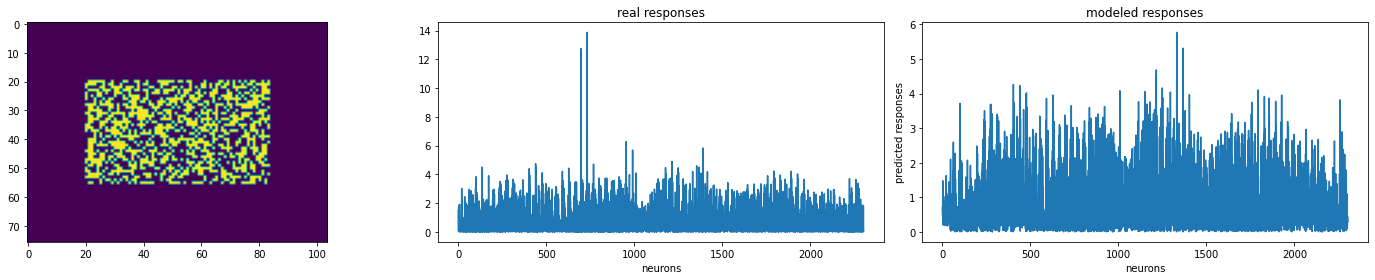

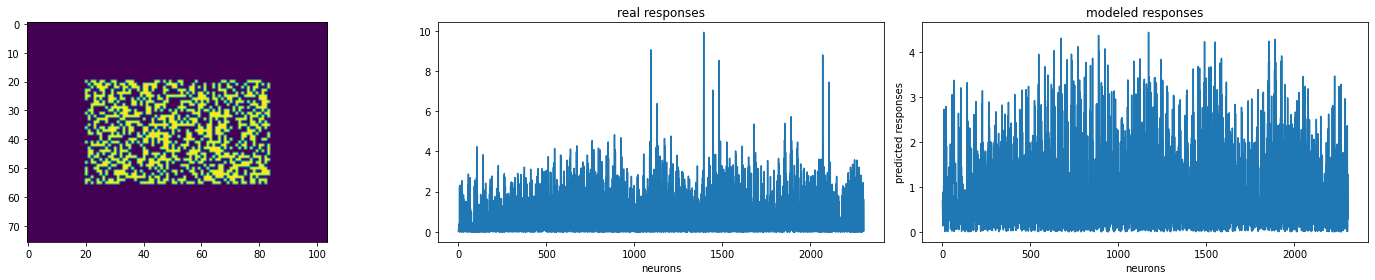

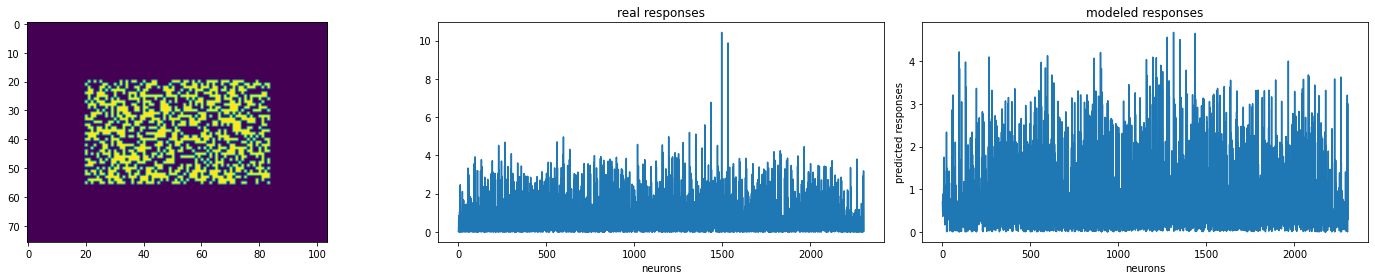

In [9]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    predicted_response = model(torch.from_numpy(input_image).view(1,1,76,104).cuda())
    predicted_response = predicted_response.squeeze().cpu().data.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[2].plot(predicted_response)
    axs[1].set_xlabel('neurons')
    axs[2].set_xlabel('neurons')
    axs[2].set_ylabel('predicted responses')
    axs[1].set_title('real responses')
    axs[2].set_title('modeled responses')

    plt.tight_layout()
    plt.show()

# STA calculation for modeled responses

In [11]:
#Load best tunned model instances - se2d_fullgaussian readout
from lurz2020.models.models import se2d_fullgaussian2d

n_seeds = 4

#Build model to load weights of instances 
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}

model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=1)
model_state = torch.load('D://inception_loop/RGC_sim_data/models/model_checkerboard_padded.pth') 
model.load_state_dict(model_state, strict=False)
if torch.cuda.is_available():
    model.cuda()
model.eval()

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
        

In [14]:
neuron = 621
total_spikes = []
sta  = np.empty([76,104])

for i in range(len(images)):
    input_image = images[i]
    predicted_response = model(torch.from_numpy(input_image).view(1,1,76,104).cuda())
    predicted_response = predicted_response.squeeze().cpu().data.numpy()[neuron]
    total_spikes.append(predicted_response)
    sta = sta + (predicted_response * input_image)

sta_neuron = sta/sum(total_spikes)

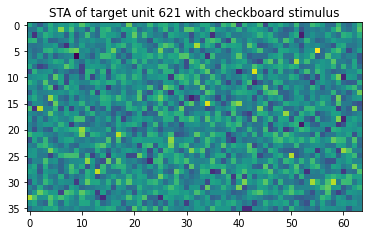

In [15]:
plt.imshow(sta[20:56,20:84])
plt.title('STA of target unit '+str(neuron)+' with checkboard stimulus')
plt.savefig("D://inception_loop/RGC_sim_data/results/STA_check_target_unit_"+str(neuron)+".png")

# MEI generation

In [ ]:
#Load model instances
from lurz2020.models.models import se2d_fullgaussian2d

n_seeds = 4

#Build model to load weights of instances 
model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 2.439}

models = []
for n in range(n_seeds):
    model = se2d_fullgaussian2d(**model_config, dataloaders=dataloaders_RGCs, seed=n)
    model_state = torch.load('D://inception_loop/RGC_sim/models/model_'+str(n)+'.pth') 
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    models.append(model)

In [ ]:
#Parameters for MEI generation

dataset_name = '20022021_check_images'

#Parameters for MEI generation
MEIParameter_tunned = {
    #1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, False, -1, 11.0)
    
    'iter_n' : 1000,         # int number of iterations to run
    'start_sigma' : 2.34,   # float starting sigma value
    'end_sigma'   : 0.16,     # float ending sigma value    
    'start_step_size' : 3.0,  # float starting step size  
    'end_step_size' : 0.125,  # float ending step size   
    'precond' : 0.13,          # float strength of gradient preconditioning filter falloff 
    'step_gain' : 0.1,      # float scaling of gradient steps
    'jitter' : 0,             # int size of translational jittering
    'blur' : True,            # bool whether to apply bluring or not 
    'norm' :  -1,             # float norm adjustment after step, negative to turn off
    'train_norm' : -1         # float norm adjustment during step, negative to turn off
    }

In [ ]:
# Generate multi MEI object
MEIS = MEI.multi_MEI_class(dataset_name = dataset_name, dat = dat, dataloaders = dataloaders_RGCs, models = models, n_seeds = 4, MEIParameter = MEIParameter_tunned)

In [ ]:
#Plot generated MEI
fig, axs = plt.subplots(figsize=(20,4))
axs.imshow(MEIS[str(TargetUnit)]['mei'])
axs.set_title('MEI of target unit '+str(TargetUnit)+' generated with model '+str(3))

In [ ]:
TargetUnit = neurons_for_MEI[0]
rf = np.load('D://inception_loop/RGC_sim/data/static27012021/RFs/'+str(TargetUnit)+'.npy')
fig, axs = plt.subplots(figsize=(20,4))
axs.imshow(rf, vmin=-1, vmax=1, cmap="gray")
axs.set_title("RGC RF")

-----------------------------